## Importing and Pre-processing Dataset

### 1. Initialising dataset and configurations

In [1]:
import pandas as pd
import numpy as np
import re 
from ucimlrepo import fetch_ucirepo 
pd.set_option('display.max_columns', None)

n_bootstrap = 9

# # Dataset 1 
# remote, data_filepath, target_label, index_col, has_index = False, "WA_Fn-UseC_-Telco-Customer-Churn.csv", "Churn", "customerID", True
# missing_placeholders, dropna, drop_dup, scaler_type, feature_sel, corr_threshold, ig_threshold, drop_cols, prune = ["?", "-"], True, False, 'm', 'ig', 0.15, 0.04, [], False
# alpha, max_iter, penalty, Lambda, random_state, meta_alpha, meta_max_iter, meta_penalty, meta_Lambda =  0.1, 1000, 'l2', 0.5, 7575, 0.02, 5000, 'l2', 0.5

# # Dataset 2
# # remote, data_filepath, target_label, index_col, has_index = True, "Adult", "income", "", False        # import from repository
# remote, data_filepath, target_label, index_col, has_index = False, "adult.csv", "income", "", False     # import from file
# missing_placeholders, dropna, drop_dup, scaler_type, feature_sel, corr_threshold, ig_threshold, drop_cols, prune = ["?", "-"], False, False, 's', 'corr', 0.00, 0.00, ['education'], False
# alpha, max_iter, penalty, Lambda, random_state, meta_alpha, meta_max_iter, meta_penalty, meta_Lambda  =  0.1, 1500, 'l1', 0.0002, 7776, 0.09, 5000, 'l2', 0.01

# # Dataset 3
# remote, data_filepath, target_label, index_col, has_index = False, "creditcard.csv", "Class", "", False
# missing_placeholders, dropna, drop_dup, scaler_type, feature_sel, corr_threshold, ig_threshold, drop_cols, prune, neg_pos = ["?", "-"], False, True, 's', 'corr', 0.35, 0.08, [], True, [20000, -1, 0]
# alpha, max_iter, penalty, Lambda, random_state, meta_alpha, meta_max_iter, meta_penalty, meta_Lambda  =  0.20, 1200, 'l2', 0.001, 7876, 0.075, 1200, 'l2', 0.5

# # Online eval dataset
remote, data_filepath, target_label, index_col, has_index = False, "B1.csv", "y", "", False
missing_placeholders, dropna, drop_dup, scaler_type, feature_sel, corr_threshold, ig_threshold, drop_cols, prune = ["?", "-"], False, True, 'm', 'corr', 0, 0.04, [], False
alpha, max_iter, penalty, Lambda, random_state, meta_alpha, meta_max_iter, meta_penalty, meta_Lambda =  0.8, 5000, 'l1', 0.0001, 7885, 0.2, 5000, 'l2', 0.5

### 2. Importing dataset from file or UCI repository

In [2]:
if remote:
    dataframe = fetch_ucirepo(name=data_filepath).data.original
    print (fetch_ucirepo(name=data_filepath).metadata.data_url)
else:
    dataframe = pd.read_csv(filepath_or_buffer=data_filepath, sep=',')
    if has_index:
        dataframe.set_index(index_col, inplace = True)
print (dataframe.shape)
dataframe.head()

(3000, 3)


,X1,X2,y
0,0.021149,0.418246,1
1,0.173735,-0.993524,0
2,0.251041,0.447588,1
3,0.458603,0.866472,0
4,-0.281439,-0.444892,1


### 3. Data Cleaning

#### a) Stripping stray characters

In [3]:
np.unique(dataframe[target_label])

array([0, 1])

In [4]:
if pd.api.types.is_string_dtype(dataframe[target_label]):
    dataframe[target_label] = dataframe[target_label].str.rstrip('.')
    print (np.unique(dataframe[target_label]))

#### b) Cleaning of duplicates

In [5]:
if drop_dup:
    dataframe = dataframe.drop_duplicates()

#### c) Cleaning/imputation of missing values

In [6]:

pattern = r'^\s*$|^(' + '|'.join(map(re.escape, missing_placeholders)) + r')$'
dataframe = dataframe.replace(pattern, np.nan, regex=True)

dataframe = dataframe.apply(pd.to_numeric, errors='ignore')

if dropna:
    dataframe = dataframe.dropna()
else:
    for col in dataframe.columns:
        modes = dataframe[col].mode()
        if len(modes) > 0:
            value = modes[0]
        else:
            value = dataframe[col].median()
        dataframe[col] = dataframe[col].fillna(value=value)

dataframe

/tmp/ipykernel_3105409/1506676276.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataframe = dataframe.apply(pd.to_numeric, errors='ignore')


,X1,X2,y
0,0.021149,0.418246,1
1,0.173735,-0.993524,0
2,0.251041,0.447588,1
3,0.458603,0.866472,0
4,-0.281439,-0.444892,1
...,...,...,...
2995,0.491668,0.427125,1
2996,-0.083604,-1.041848,0
2997,-0.064109,-1.031312,0
2998,0.771608,-0.793978,0


#### d) Dropping redundant columns

In [7]:
dataframe = dataframe.drop(drop_cols, axis=1)
dataframe

,X1,X2,y
0,0.021149,0.418246,1
1,0.173735,-0.993524,0
2,0.251041,0.447588,1
3,0.458603,0.866472,0
4,-0.281439,-0.444892,1
...,...,...,...
2995,0.491668,0.427125,1
2996,-0.083604,-1.041848,0
2997,-0.064109,-1.031312,0
2998,0.771608,-0.793978,0


#### e) Pruning rows to reduce positive-negative bias in dataset 

In [8]:
if prune:
    neg_count, pos_count = neg_pos[0], neg_pos[1]
    neg_val = neg_pos[2]

    df_target_neg = dataframe[dataframe[target_label] == neg_val]
    df_target_pos = dataframe[dataframe[target_label] != neg_val]

    if neg_count > 0:
        df_sampled_target_neg = df_target_neg.sample(n=neg_count, random_state=2*random_state+5)
    else:
        df_sampled_target_neg = df_target_neg

    if pos_count > 0:
        df_sampled_target_pos = df_target_pos.sample(n=pos_count, random_state=3*random_state+4)
    else:
        df_sampled_target_pos = df_target_pos 

    dataframe = pd.concat([df_sampled_target_pos, df_sampled_target_neg])
    print (dataframe.shape)


### 4. Extracting features and labels

In [9]:
Features = dataframe.drop(target_label, axis=1)
Labels = pd.DataFrame(dataframe[target_label], columns=[target_label])

### 5. Binarisation, discretisation, encoding

#### a) Identifying numeric columns

In [10]:
num_cols = Features.select_dtypes(include=['number']).columns.to_list()
num_cols

['X1', 'X2']

#### b) Label-encoding boolean (Yes/No) columns

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

binary_cols = Features.columns[Features.nunique() <= 2]
for col in binary_cols:
    Features[col] = encoder.fit_transform(Features[col])
Features[binary_cols]

""
0
1
2
3
4
...
2995
2996
2997
2998


In [12]:
Labels[target_label] = encoder.fit_transform(Labels[target_label])
np.unique(Labels[target_label])

array([0, 1])

#### c) One-hot encoding of remaining non-numeric features

In [13]:
Features = pd.get_dummies(Features)
Features

,X1,X2
0,0.021149,0.418246
1,0.173735,-0.993524
2,0.251041,0.447588
3,0.458603,0.866472
4,-0.281439,-0.444892
...,...,...
2995,0.491668,0.427125
2996,-0.083604,-1.041848
2997,-0.064109,-1.031312
2998,0.771608,-0.793978


### 6. Scaling numeric values

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

if scaler_type == 'm':
    scaler = MinMaxScaler()
elif scaler_type == 's':
    scaler = StandardScaler()
Features[num_cols] = scaler.fit_transform(Features[num_cols])
Features

,X1,X2
0,0.505470,0.657384
1,0.566144,0.102054
2,0.596884,0.668927
3,0.679418,0.833698
4,0.385150,0.317862
...,...,...
2995,0.692566,0.660877
2996,0.463817,0.083045
2997,0.471569,0.087190
2998,0.803880,0.180547


## Feature Selection

#### 1. Using correlation with target
Finding the columns most correlated with target

In [15]:
if feature_sel == 'corr':
    correlations = Features.corrwith(Labels[target_label])
    correlations = abs(correlations).sort_values(ascending=False)
    correlations = correlations[correlations > corr_threshold]
    print(correlations)

X1    0.006938
X2    0.002624
dtype: float64


#### 2. Using information gain with respect to target

In [16]:
def H(col):
    P_v_col = np.bincount(col) / len(col)
    return -np.sum(P_v_col * np.log2(P_v_col, where=P_v_col > 0))

def H_split(col, target):
    col_values = np.unique(col)
    len_S = len(col)
    H_S_split = 0
    for v_k in col_values:
        S_k = target[col == v_k]
        H_S_split += len(S_k) / len_S  * H(S_k)
    return H_S_split

def IG(features, labels, target_label):
    H_S = H(labels[target_label])
    IG = {}
    for col in features.columns:
        H_S_split = H_split(features[col], labels[target_label])
        IG[col] = H_S - H_S_split
    return pd.Series(IG)


if feature_sel == 'ig':
    DiscreteFeatures = Features.copy()
    for col in num_cols:
        DiscreteFeatures[col] =  pd.cut(DiscreteFeatures[col], bins=10)
    IGs = IG(Features, Labels, target_label)
    IGs = abs(IGs).sort_values(ascending=False)
    IGs = IGs[IGs > ig_threshold]
    print(IGs)


#### 3. Dropping columns with low correlation / information gain

In [17]:
if feature_sel == 'corr':
    Features = Features[correlations.keys().to_list()]
elif feature_sel == 'ig':
    Features = Features[IGs.keys().to_list()]
Features

,X1,X2
0,0.505470,0.657384
1,0.566144,0.102054
2,0.596884,0.668927
3,0.679418,0.833698
4,0.385150,0.317862
...,...,...
2995,0.692566,0.660877
2996,0.463817,0.083045
2997,0.471569,0.087190
2998,0.803880,0.180547


## Implementing Logistic Regression

### 1. Sigmoid function (hypothesis)
Sigmoid function that can be applied on arrays or matrices:

In [18]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

### 2. L1 and L2 Regularisation

In [19]:
def l1_reg (D_J_W, W, Lambda, m):
    return D_J_W + Lambda * np.sign(W)

def l2_reg (D_J_W, W, Lambda, m):
    return D_J_W + Lambda * (1/m) * W

### 3. Training update rule (gradient descent)

X is a matrix whose rows each represent the feature vector of a sample \
Y is a vector containing the label for each training sample per row of X\
W is a vector containing the weight (parameter) for each feature per column of X, and the bias corresponding to an augmented all-1 column of X

In [20]:
def gradient_descent (m, W, X, Y, iterations, alpha, Lambda, regularize):
    alpha0= alpha
    for t in range (iterations):
        # alpha = alpha0 / (1 + t * alpha0)
        h_W_X = sigmoid (np.matmul(X, W))
        D_J_W = 1/m * np.matmul(np.transpose(X), (Y - h_W_X))
        D_J_W = regularize(D_J_W, W, Lambda, m)
        W = W + alpha * D_J_W
    return W

### 4. Prediction using predicted weights (parameters)

In [21]:
def predict_proba_Y (X, W):
    Y_hat = sigmoid(np.matmul(X, W))
    return Y_hat

def predict_Y (X, W):
    Y = (predict_proba_Y(X, W) >= 0.5).astype(int)
    return Y

The above functions are combined into the class `PyLogReg` that can be used almost as a drop-in replacement for scikit-learn's LogisticRegression. The `fit()` and `predict()` methods have signatures similar to the `LogisticRegression` counterparts. They receive `X_df` (a pandas dataframe of the dataset's features) and `y_srs` (a pandas series of the training labels) as arguments.

In [22]:
class PyLogReg:
    def __init__(self, alpha=1.0, max_iter=100, penalty='l2', Lambda=1.0):
        self.alpha = alpha
        self.max_iter = max_iter
        self.W = None
        self.Lambda = Lambda
        if penalty == 'l1':
            self.regularize = l1_reg
        elif penalty == 'l2':
            self.regularize = l2_reg

    def fit (self, X_df, y_srs):
        alpha = self.alpha 
        X = X_df.to_numpy(dtype=float)
        Y = np.transpose(y_srs.to_numpy(dtype=float)).reshape(-1, 1)
        n = X.shape[1] + 1
        m = X.shape[0]
        X = np.hstack ((np.ones((m, 1)), X))
        W = np.zeros((n,1))
        self.W = gradient_descent (m, W, X, Y, self.max_iter, self.alpha, self.Lambda, self.regularize)

    def predict (self, X_df, name="predictions"):
        X = X_df.to_numpy(dtype=float)
        X = np.hstack ((np.ones((X.shape[0], 1)), X))
        Y = predict_Y (X, self.W)
        return pd.Series(Y.flatten(), name=name)
    
    def predict_proba (self, X_df, name="predictions_proba"):
        X = X_df.to_numpy(dtype=float)
        X = np.hstack ((np.ones((X.shape[0], 1)), X))
        Y_hat = predict_proba_Y (X, self.W)
        return pd.Series(Y_hat.flatten(), name=name)

## Splitting the dataset

In [23]:
from sklearn.model_selection import train_test_split

X = Features
y = Labels[target_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_vald, y_train, y_vald = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state*7+39)

## Training and testing on LR (`PyLogReg`)

In [24]:
from sklearn.metrics import accuracy_score

clf = PyLogReg (alpha=alpha, max_iter=max_iter, Lambda=Lambda, penalty=penalty)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of PyLogReg classifier: {accuracy:.6f}")

test_result = X_test.copy()
test_result[target_label] = encoder.inverse_transform(y_pred)
test_result

Accuracy of PyLogReg classifier: 0.508333


,X1,X2,y
1758,0.582851,0.641851,1
1585,0.486611,0.256738,0
1799,0.848141,0.347034,0
2174,0.694480,0.545051,1
1654,0.677443,0.595878,1
...,...,...,...
2049,0.687182,0.404520,0
2566,0.678988,0.158688,0
969,0.466110,0.126546,0
53,0.278892,0.330350,0


## Bagging of training set

In [25]:
clf_bag, y_pred_bag, y_pred_proba_bag = [], [], []

for i in range(n_bootstrap):
    X_train_i = X_train.sample(frac=1, replace=True, random_state=random_state+i*3)
    y_train_i = y_train.sample(frac=1, replace=True, random_state=random_state+i*3)

    clf_i = PyLogReg (alpha=alpha, max_iter=max_iter, Lambda=Lambda, penalty=penalty)
    clf_i.fit(X_train_i, y_train_i)
    
    y_pred_i = clf_i.predict(X_test, f"y_{i}")
    y_pred_proba_i = clf_i.predict_proba(X_test, f"y_proba_{i}")

    clf_bag.append (clf_i)

    y_pred_bag.append (y_pred_i)
    y_pred_proba_bag.append (y_pred_proba_i)

## Ensembling methods

### 1. Voting ensemble

In [26]:
y_vote_matrix = pd.DataFrame({s.name: s for s in y_pred_bag})
y_vote_matrix['y_vote'] = y_vote_matrix.mode(axis=1).iloc[:, 0]
y_vote = y_vote_matrix['y_vote'] 

y_vote_proba_matrix = pd.DataFrame({s.name: s for s in y_pred_proba_bag})
y_vote_proba_matrix['y_vote_proba'] = y_vote_proba_matrix.median(axis=1)
y_vote_proba = y_vote_proba_matrix['y_vote_proba'] 

y_vote_matrix

,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_vote
0,1,0,1,1,0,1,1,0,1,1
1,1,0,1,1,1,1,0,0,0,1
2,0,0,1,1,0,1,0,0,1,0
3,1,0,1,1,0,1,1,0,1,1
4,1,0,1,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
595,1,0,1,1,0,1,0,0,1,1
596,0,0,1,1,0,1,0,0,1,0
597,1,0,1,0,1,1,0,0,0,0
598,1,0,1,1,1,1,1,1,0,1


In [27]:
accuracy = accuracy_score(y_test, y_vote)
print(f"Accuracy of majority of bagged PyLogReg classifiers: {accuracy:.6f}")

Accuracy of majority of bagged PyLogReg classifiers: 0.671667


### 2. Stacking ensemble (with validation)

At first the bagged LR predictors will be run on the validation set.

In [28]:
y_vald_pred_bag = []

for i in range(n_bootstrap):
    y_vald_pred_i = clf_bag[i].predict (X_vald, f"y_vald_{i}")
    y_vald_pred_bag.append (y_vald_pred_i)

y_stack_matrix = pd.DataFrame({s.name: s for s in y_vald_pred_bag})
y_stack_matrix

,y_vald_0,y_vald_1,y_vald_2,y_vald_3,y_vald_4,y_vald_5,y_vald_6,y_vald_7,y_vald_8
0,1,0,1,1,0,1,1,1,1
1,1,0,1,1,1,1,1,1,0
2,1,0,1,1,0,1,1,0,1
3,0,0,1,1,0,1,0,0,1
4,1,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
475,1,0,1,1,0,1,1,0,1
476,1,0,1,1,0,1,1,0,1
477,0,0,1,1,0,1,0,0,1
478,1,0,1,1,0,1,0,0,1


Predictions on the validation set will be added as feature columns to the validation feature set in order to make an augmented feature matrix for meta-classifier.

In [29]:
X_stack_aug_vald = pd.concat([X_vald.reset_index(drop=True), y_stack_matrix.reset_index(drop=True)], axis=1)
X_stack_aug_vald

,X1,X2,y_vald_0,y_vald_1,y_vald_2,y_vald_3,y_vald_4,y_vald_5,y_vald_6,y_vald_7,y_vald_8
0,0.507694,0.658830,1,0,1,1,0,1,1,1,1
1,0.209905,0.865020,1,0,1,1,1,1,1,1,0
2,0.690096,0.594193,1,0,1,1,0,1,1,0,1
3,0.854347,0.509897,0,0,1,1,0,1,0,0,1
4,0.260872,0.639734,1,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
475,0.605498,0.654035,1,0,1,1,0,1,1,0,1
476,0.797462,0.678605,1,0,1,1,0,1,1,0,1
477,0.901222,0.406449,0,0,1,1,0,1,0,0,1
478,0.685506,0.379107,1,0,1,1,0,1,0,0,1


Meta-classifier (an instance of `PyLogReg`) will be trained on the augmented validation set.

In [30]:
metaclf = PyLogReg (alpha=meta_alpha, max_iter=meta_max_iter, penalty=meta_penalty, Lambda=meta_Lambda)
metaclf.fit (X_stack_aug_vald, y_vald)

The original testing set will be augmented with base classifier (bagged LR) predictions

In [31]:
X_stack_aug_test = pd.concat([X_test.reset_index(drop=True), y_vote_matrix.reset_index(drop=True)], axis=1)
X_stack_aug_test = X_stack_aug_test.drop(['y_vote'], axis=1)
X_stack_aug_test

,X1,X2,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8
0,0.582851,0.641851,1,0,1,1,0,1,1,0,1
1,0.486611,0.256738,1,0,1,1,1,1,0,0,0
2,0.848141,0.347034,0,0,1,1,0,1,0,0,1
3,0.694480,0.545051,1,0,1,1,0,1,1,0,1
4,0.677443,0.595878,1,0,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
595,0.687182,0.404520,1,0,1,1,0,1,0,0,1
596,0.678988,0.158688,0,0,1,1,0,1,0,0,1
597,0.466110,0.126546,1,0,1,0,1,1,0,0,0
598,0.278892,0.330350,1,0,1,1,1,1,1,1,0


Lastly, the meta-classifier will be run on the augmented testing set.

In [32]:
y_stack = metaclf.predict(X_stack_aug_test)
y_stack_proba = metaclf.predict_proba(X_stack_aug_test)

accuracy = accuracy_score(y_test, y_stack)
print(f"Accuracy of stacking with meta-classifier: {accuracy:.6f}")

Accuracy of stacking with meta-classifier: 0.928333


## Performance Evaluation

#### 1. Preparing performance metrics

In [33]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, f1_score, roc_auc_score, precision_recall_curve, auc

def specificity (y_test, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    return TN/(TN+FP)

def aupr (y_test, y_pred_proba):
    precision_y, recall_y, threshold = precision_recall_curve(y_test, y_pred_proba)
    return auc (recall_y, precision_y)

performance_metrics = {
    'Accuracy' : accuracy_score,
    'Sensitivity' : recall_score,
    'Specificity': specificity,
    'Precision': precision_score,
    'F1-score': f1_score,
    'AUROC' : roc_auc_score,
    'AUPR' : aupr,
}

need_proba = ['AUROC', 'AUPR']

def all_perf_metrics (y_test, y_pred, y_pred_proba):
    metric_vals = {}
    for k in performance_metrics:
        if k in need_proba:
            metric_vals[k] = performance_metrics[k](y_test, y_pred_proba)
        else:
            metric_vals[k] = performance_metrics[k](y_test, y_pred)
    return metric_vals

metric_results_comp = pd.DataFrame (columns=performance_metrics.keys(), index=pd.Index([], name='Method'))

#### 2. Calculating metrics for bagged LR predictors

In [34]:
for i in range(len(y_pred_bag)):
    metric_results_comp.loc[f'LR_{i}'] = all_perf_metrics (y_test, y_pred_bag[i], y_pred_proba_bag[i])

/home/glob/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 3. Drawing violin plots for bagged LR predictors

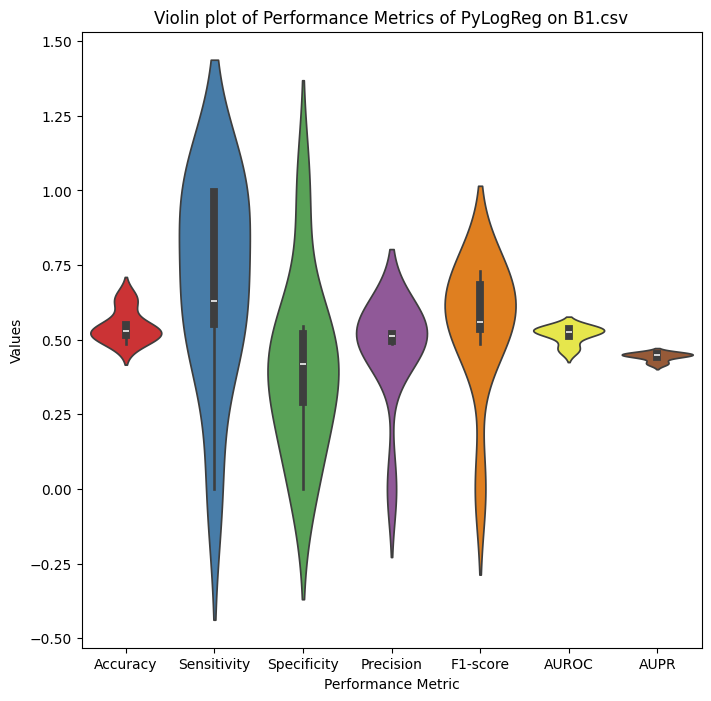

In [35]:
lr_metrics_violin = metric_results_comp.melt(var_name='Performance Metric', value_name='Values')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.violinplot(x='Performance Metric', y='Values', data=lr_metrics_violin, palette="Set1", hue='Performance Metric', legend=False)
plt.title(f'Violin plot of Performance Metrics of PyLogReg on {data_filepath}')
plt.show()

#### 4. Compiling metrics for average of bagged LR

In [36]:
metric_results_comp.loc['LR'] = [f"{m:.6f} ± {s:.4f}" for m, s in zip(metric_results_comp.mean(axis=0), metric_results_comp.std(axis=0))]
metric_results_comp = metric_results_comp.loc[['LR']]

#### 5. Compiling metrics for ensembling methods

In [37]:
metric_results_comp.loc['Voting ensemble'] = all_perf_metrics (y_test, y_vote, y_vote_proba)
metric_results_comp.loc['Stacking ensemble'] = all_perf_metrics (y_test, y_stack, y_stack_proba)

metric_results_comp

,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPR
Method,,,,,,,
LR,0.545926 ± 0.0531,0.693013 ± 0.3395,0.407407 ± 0.2862,0.464204 ± 0.1767,0.546516 ± 0.2223,0.516692 ± 0.0288,0.443515 ± 0.0134
Voting ensemble,0.671667,0.993127,0.368932,0.597107,0.745806,0.553209,0.458005
Stacking ensemble,0.928333,0.941581,0.915858,0.913333,0.927242,0.967549,0.969211
